# ECSE415 - Introduction to Computer Vision
## Tutorial 8 - Object Detection & Image Segmentation
This tutorial introduces two popular object detection models—YOLOv5 and Mask R-CNN. We'll use pre-trained models to detect objects in a sample image.
Then we will move on to clustering based segmentation models.

## Environment Setup
First, let's install the required libraries.

In [ ]:
# !pip install ultralytics
# !git clone https://github.com/ultralytics/yolov5  # clone
# %cd yolov5
# %pip install -qr requirements.txt comet_ml  # install

Cloning into 'yolov5'...
remote: Enumerating objects: 17022, done.
remote: Total 17022 (delta 0), reused 0 (delta 0), pack-reused 17022 (from 1)
Receiving objects: 100% (17022/17022), 15.62 MiB | 20.91 MiB/s, done.
Resolving deltas: 100% (11694/11694), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 4.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 697.1/697.1 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.0/879.0 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 969.5/969.5 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 10.6 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2
import utils

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load and Test YOLOv5

YOLO is a popular object detection model known for its speed and accuracy. We'll use GluonCV's pretrained YOLOv5.

In [ ]:
!python /content/yolov5/segment/predict.py --weights yolov5s-seg.pt --img 640 --conf 0.25 --source '/content/drive/My Drive/Colab Notebooks/ECSE 415 Tutorials/Tutorial_8/dog.jpg'

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
segment/predict: weights=['yolov5s-seg.pt'], source=/content/drive/My Drive/Colab Notebooks/ECSE 415 Tutorials/Tutorial_8/dog.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/predict-seg, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1, retina_masks=False
YOLOv5 🚀 v7.0-378-g2f74455a Python-3.10.12 torch-2.5.0+cu121 CPU

100% 14.9M/14.9M [00:00<00:00, 111MB/s] 

Fusing layers... 
YOLOv5s-seg 

YOLOv5 🚀 v7.0-378-g2f74455a Python-3.10.12 torch-2.5.0+cu121 CPU


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.6/107.7 GB disk)


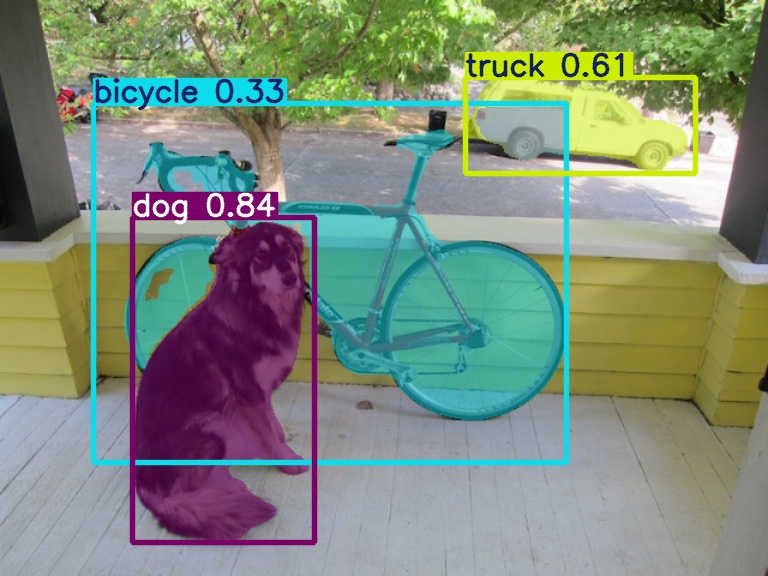

In [ ]:
display = utils.notebook_init()  # checks
display.Image(filename='/content/yolov5/runs/predict-seg/exp/dog.jpg', width=600)

## Load and Test Mask R-CNN
Mask R-CNN extends Faster R-CNN by adding a branch for predicting segmentation masks. It can perform both object detection and instance segmentation.

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 103MB/s]


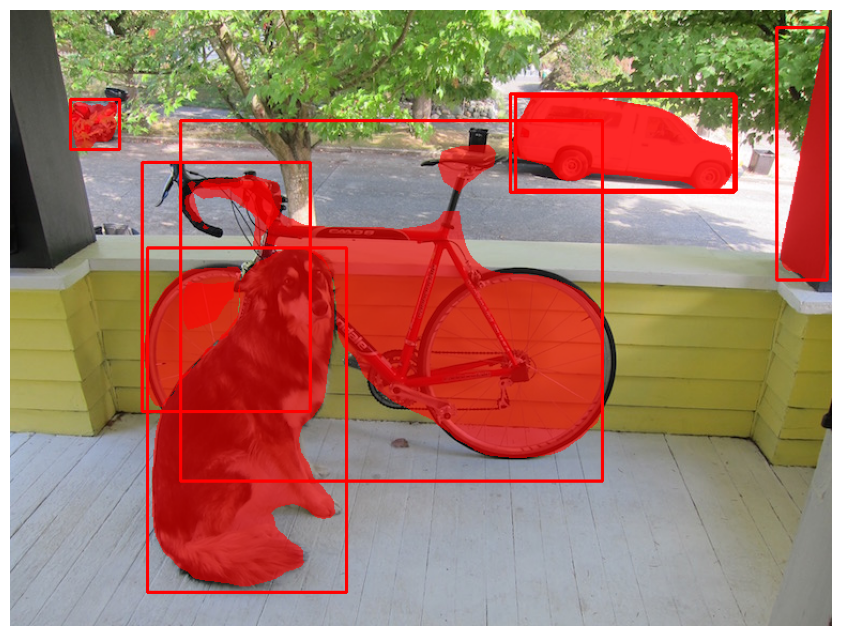

In [ ]:
# Load Mask R-CNN model
mask_rcnn = maskrcnn_resnet50_fpn(pretrained=True)
mask_rcnn.eval()  # Set model to evaluation mode

# Load a sample image and prepare for input
img = cv2.imread('/content/drive/My Drive/Colab Notebooks/ECSE 415 Tutorials/Tutorial_8/dog.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_tensor = F.to_tensor(img)
img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension

# Perform detection
with torch.no_grad():
    predictions = mask_rcnn(img_tensor)

# Visualize results
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
img_np = np.array(img)

# Process each detected object
for i in range(len(predictions[0]["boxes"])):
    # Only show objects with a high score
    if predictions[0]["scores"][i] > 0.25:
        # Get bounding box coordinates and mask
        box = predictions[0]["boxes"][i].cpu().numpy().astype(int)
        mask = predictions[0]["masks"][i, 0].cpu().numpy()

        # Draw bounding box
        cv2.rectangle(img_np, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)

        # Overlay mask with transparency
        mask_img = (mask > 0.5).astype(np.uint8) * 255
        img_np[mask_img == 255] = (0.6 * np.array([255, 0, 0]) + 0.4 * img_np[mask_img == 255]).astype(np.uint8)

# Display the final image with bounding boxes and masks
plt.imshow(img_np)
plt.axis('off')
plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from skimage import segmentation, color
from sklearn import mixture

## K-Means and GMM Clustering

38930.726473968825


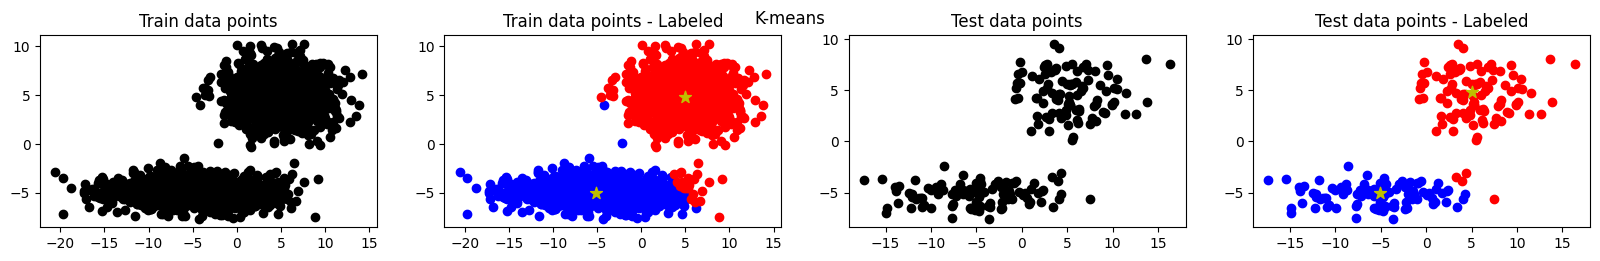

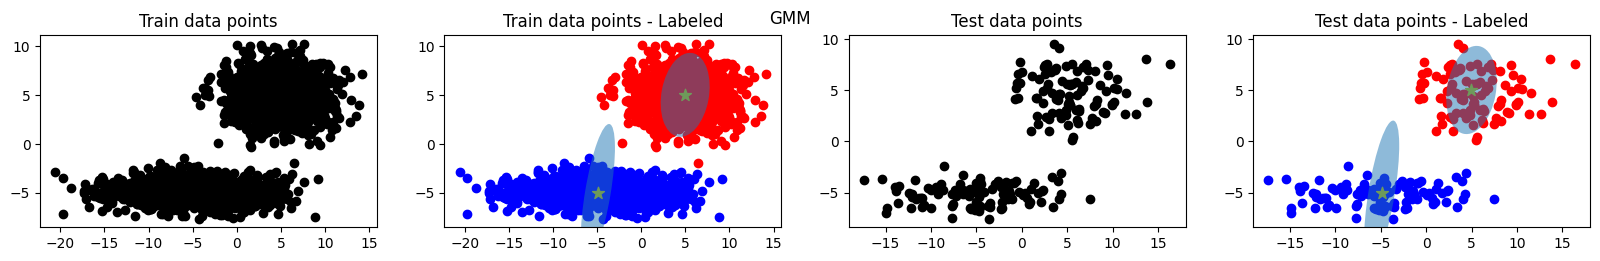

In [ ]:
# generate 2-dimensinonal random datapoints in two different clusters

# Train data
traind = np.float32(
       np.vstack((
       np.random.normal(loc=np.array([5,5]), scale=np.array([3,2]), size=(1000,2)),
       np.random.normal(loc=np.array([-5,-5]), scale=np.array([5,1]), size=(1000,2)))))

# Test data
testd = np.float32(
       np.vstack((
       np.random.normal(loc=np.array([5,5]), scale=np.array([3,2]), size=(100,2)),
       np.random.normal(loc=np.array([-5,-5]), scale=np.array([5,1]), size=(100,2)))))

#---------------------------------- K-means --------------------------------------------


# Training
# Understanding: https://docs.opencv.org/3.4/de/d4d/tutorial_py_kmeans_understanding.html
#
# K-Means Input parameters:
# samples : It should be of np.float32 data type, and each feature should be put in a single column.
# nclusters(K) : Number of clusters required at end
# bestLabels	Input/output integer array that stores the cluster indices for every sample.
# criteria : It is the iteration termination criteria. When this criteria is satisfied, algorithm iteration stops.
#            Actually, it should be a tuple of 3 parameters. They are ( type, max_iter, epsilon ):
#            3.a - type of termination criteria : It has 3 flags as below:
#                  cv2.TERM_CRITERIA_EPS - stop the algorithm iteration if specified accuracy, epsilon, is reached.
#                  cv2.TERM_CRITERIA_MAX_ITER - stop the algorithm after the specified number of iterations, max_iter.
#                  cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER - stop the iteration when any of the above condition is met.
#            3.b - max_iter - An integer specifying maximum number of iterations.
#            3.c - epsilon - Required accuracy
# attempts : Flag to specify the number of times the algorithm is executed using different initial labellings.
#            The algorithm returns the labels that yield the best compactness. This compactness is returned as output.
# flags : This flag is used to specify how initial centers are taken. Normally two flags are used for this :
#         cv2.KMEANS_PP_CENTERS (Use kmeans++ center initialization by Arthur and Vassilvitskii [Arthur2007])  and cv2.KMEANS_RANDOM_CENTERS (random centers).
#
# K-Means output parameters:
# compactness : It is the sum of squared distance from each point to their corresponding centers.
# labels : This is the label array where each element marked ‘0’, ‘1’.....
# centers : This is array of centers of clusters.

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1)
compactness, labels, centers = cv2.kmeans(traind, 2, None, criteria, 10, flags=cv2.KMEANS_RANDOM_CENTERS)

print(compactness)

A = traind[labels.ravel()==0]
B = traind[labels.ravel()==1]

plt.figure(figsize=(20,2.5))
plt.subplot(141)
plt.plot(traind[:,0], traind[:,1], "ko")
plt.title("Train data points")
plt.subplot(142)
plt.scatter(A[:,0], A[:,1], color='b')
plt.scatter(B[:,0], B[:,1], color='r')
plt.scatter(centers[:,0], centers[:,1], s=80, color='y', marker='*')
plt.title("Train data points - Labeled")


# Test
# Find the euclidean distance between the test datapoints and the two cluster centers.
# Test datapoint belongs to the cluster whose mean is closer to the test datapoint.

labels = np.argmin(np.sum((testd[None,:,:] - centers[:,None,:])**2, -1),0)
A = testd[labels==0]
B = testd[labels==1]

plt.subplot(143)
plt.plot(testd[:,0], testd[:,1], "ko")
plt.title("Test data points")
plt.subplot(144)
plt.scatter(A[:,0], A[:,1], color='b')
plt.scatter(B[:,0], B[:,1], color='r')
plt.scatter(centers[:,0], centers[:,1], s=80, color='y', marker='*')
plt.title("Test data points - Labeled")
plt.suptitle("K-means")
plt.show()

#---------------------------------- GMM --------------------------------------------

# A helper function to draw variance
def make_ellipses(gmm, ax):
    K = gmm.means_.shape[0]
    for n in range(K):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1], angle=80+angle)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

# https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html
# sklearn.mixture.GaussianMixture(n_components=1,
#                                 covariance_type=’full’,   #{‘full’ (default), ‘tied’, ‘diag’, ‘spherical’}
#                                 tol=0.001,
#                                 reg_covar=1e-06,
#                                 max_iter=100,
#                                 n_init=1,
#                                 init_params=’kmeans’,     #{‘kmeans’, ‘random’}
#                                 weights_init=None,
#                                 means_init=None,
#                                 precisions_init=None,
#                                 random_state=None,
#                                 warm_start=False,
#                                 verbose=0,
#                                 verbose_interval=10)

# define a GMM class
clf = mixture.GaussianMixture(n_components=2, covariance_type='full')

# fit GMM on train data
clf.fit(traind)

# the centers of the fitted GMM
centers = clf.means_

# predict cluster membership from the fitted GMM
label = clf.predict(traind)

A = traind[label==0]
B = traind[label==1]

plt.figure(figsize=(20,2.5))
plt.subplot(141)
plt.plot(traind[:,0], traind[:,1],"ko")
plt.title("Train data points")
h = plt.subplot(142)
plt.scatter(A[:,0], A[:,1], color='b')
plt.scatter(B[:,0], B[:,1], color='r')
plt.scatter(centers[:,0], centers[:,1], s=80, color='y', marker='*')
make_ellipses(clf, h)
plt.title("Train data points - Labeled")

# predict cluster membership from the fitted GMM
label = clf.predict(testd)

A = testd[label==0]
B = testd[label==1]

plt.subplot(143)
plt.plot(testd[:,0], testd[:,1],"ko")
plt.title("Test data points")
h = plt.subplot(144)
plt.scatter(A[:,0], A[:,1], color='b')
plt.scatter(B[:,0], B[:,1], color='r')
plt.scatter(centers[:,0], centers[:,1], s=80, color='y', marker='*')
make_ellipses(clf, h)
plt.title("Test data points - Labeled")

plt.suptitle("GMM")
plt.show()

# print(np.unique(label))

## K-means

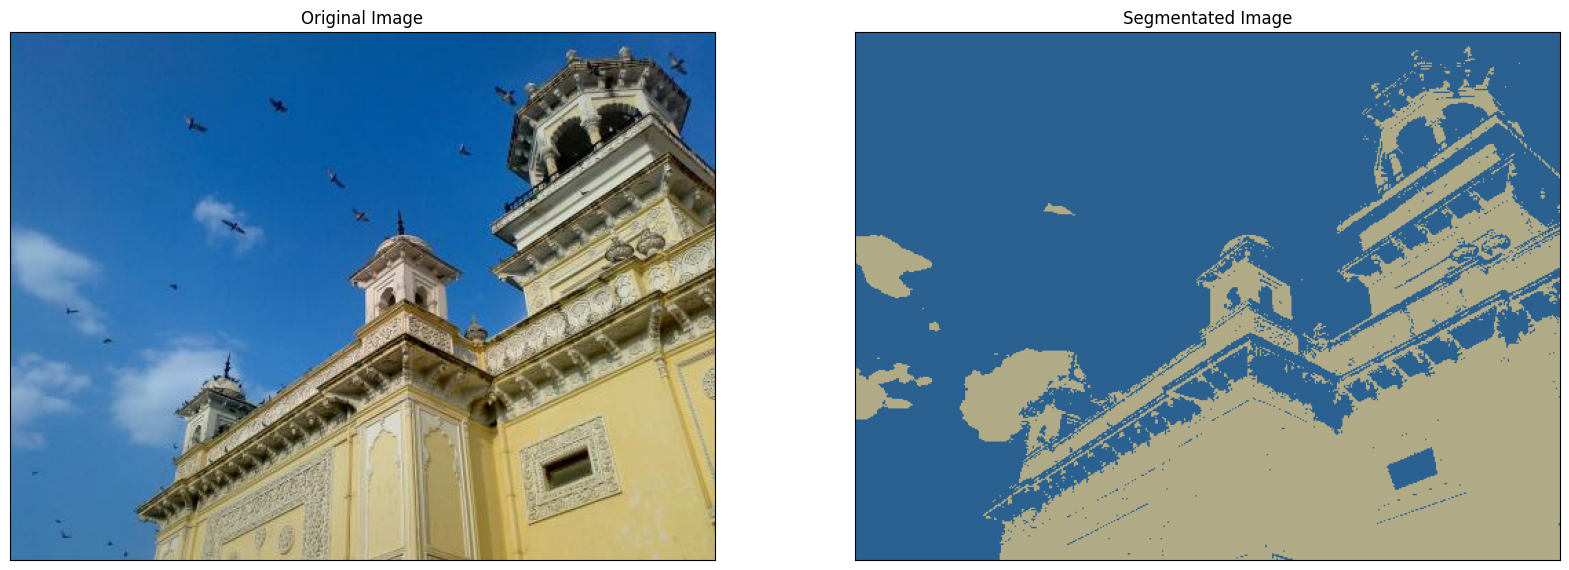

In [ ]:
img = cv2.cvtColor(cv2.imread('/content/drive/My Drive/Colab Notebooks/ECSE 415 Tutorials/Tutorial_8/home.jpg'), cv2.COLOR_BGR2RGB)
Z = img.reshape((-1,3))

# convert to np.float32
Z = np.float32(Z)

# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
ret, label, center=cv2.kmeans(Z, K, None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

# Now convert it back to uint8, and reshape
center = np.uint8(center)
out = center[label.flatten()]
out = out.reshape((img.shape))

plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(img)
plt.title("Original Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122)
plt.imshow(out)
plt.title("Segmentated Image"), plt.xticks([]), plt.yticks([])
plt.show()

## GMM

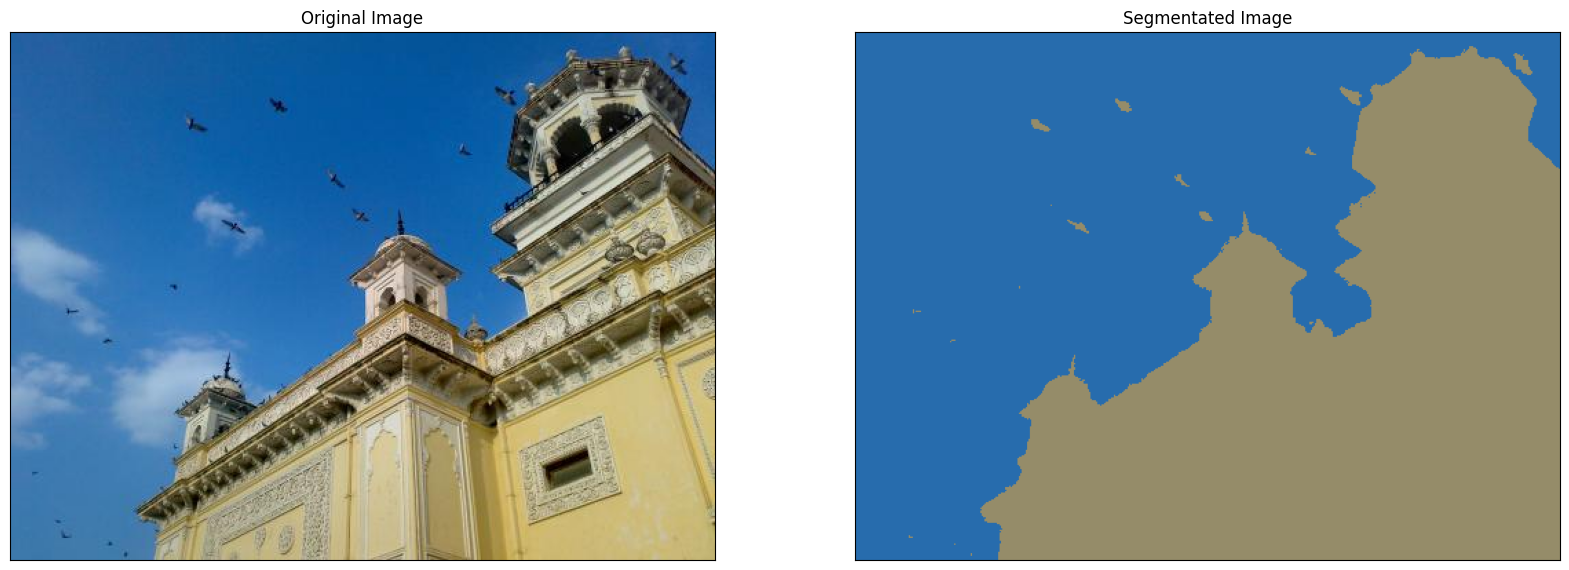

In [ ]:
# Read an image
img = cv2.cvtColor(cv2.imread('/content/drive/My Drive/Colab Notebooks/ECSE 415 Tutorials/Tutorial_8/home.jpg'), cv2.COLOR_BGR2RGB)

# Arrange img to a feature matrix and convert it to np.float32
Z = img.reshape((-1,3))
Z = np.float32(Z)

# fit GMM on Z
clf = mixture.GaussianMixture(n_components=2, covariance_type='full')
clf.fit(Z)

# predict clusters from the fitted GMM
label = clf.predict(Z)

# create a segmentation image
center = np.uint8(clf.means_)
out = center[label.flatten()]
out = out.reshape((img.shape))

# display
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(img)
plt.title("Original Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122)
plt.imshow(out)
plt.title("Segmentated Image"), plt.xticks([]), plt.yticks([])
plt.show()